In [24]:
import warnings
warnings.filterwarnings("ignore")  # Suppress all warnings

# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Load and preprocess the dataset
df = pd.read_csv("rest_area_occupancy_merged.csv")
df_clean = df.dropna()

# Encode categorical features
df_encoded = df_clean.copy()
label_encoders = {}
for col in df_encoded.select_dtypes(include='object').columns:
    if col != "Occupancy":
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])
        label_encoders[col] = le

# Encode target variable and scale features
le_target = LabelEncoder()
y = le_target.fit_transform(df_encoded["Occupancy"])
X = df_encoded.drop(columns=["Occupancy"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Define models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=3000, random_state=42),
    "XGBoost": XGBClassifier(eval_metric="mlogloss", random_state=42),
    "Naive Bayes": GaussianNB(),
    "k-NN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(kernel="linear", class_weight='balanced', random_state=42)
}

# Model evaluation
results = {}
reports = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    rep = classification_report(y_test, y_pred, target_names=le_target.classes_, zero_division=0, output_dict=True)
    reports[name] = rep
    print(f"{name}: Accuracy = {accuracy:.4f}")

# Summary table
f1_weighted = {name: reports[name]["weighted avg"]["f1-score"] for name in models}
print("\nSummary of results (accuracy and weighted F1-score):\n")
summary_df = pd.DataFrame({
    "Accuracy": results,
    "F1-score weighted": f1_weighted
}).sort_values(by="Accuracy", ascending=False)
print(summary_df)

Decision Tree: Accuracy = 0.5556
Random Forest: Accuracy = 0.5809
Gradient Boosting: Accuracy = 0.6562
Logistic Regression: Accuracy = 0.5783
XGBoost: Accuracy = 0.5871
Naive Bayes: Accuracy = 0.4401
k-NN: Accuracy = 0.5678
SVM: Accuracy = 0.4462

Summary of results (accuracy and weighted F1-score):

                     Accuracy  F1-score weighted
Gradient Boosting    0.656168           0.643729
XGBoost              0.587052           0.582818
Random Forest        0.580927           0.578898
Logistic Regression  0.578303           0.541715
k-NN                 0.567804           0.568839
Decision Tree        0.555556           0.556546
SVM                  0.446194           0.460996
Naive Bayes          0.440070           0.460710


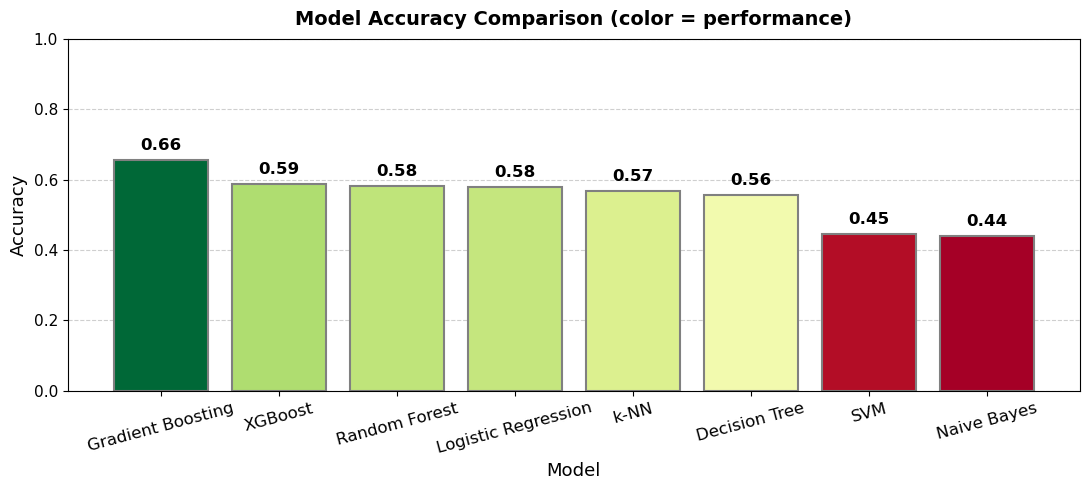

In [22]:
import matplotlib.pyplot as plt

# Prepare data for plotting
sorted_results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))
sorted_keys = list(sorted_results.keys())
sorted_values = np.array(list(sorted_results.values()))
norm = (sorted_values - sorted_values.min()) / (sorted_values.max() - sorted_values.min())

# Get colormap (green = best, red = worst)
cmap = plt.colormaps['RdYlGn']
colors = cmap(norm)

fig, ax = plt.subplots(figsize=(11, 5))
bars = ax.bar(sorted_keys, sorted_values, color=colors, edgecolor="gray", linewidth=1.5)

# Add horizontal grid lines
ax.yaxis.grid(True, linestyle='--', alpha=0.6)
ax.set_axisbelow(True)

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        yval + 0.02,
        f"{yval:.2f}",
        ha='center', va='bottom', fontsize=12, fontweight='bold'
    )

ax.set_ylim(0, 1)
ax.set_xlabel("Model", fontsize=13)   # <-- ADD X AXIS LABEL
ax.set_ylabel("Accuracy", fontsize=13)
ax.set_title("Model Accuracy Comparison (color = performance)", fontsize=14, fontweight='bold', pad=10)
plt.xticks(rotation=15, fontsize=12)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

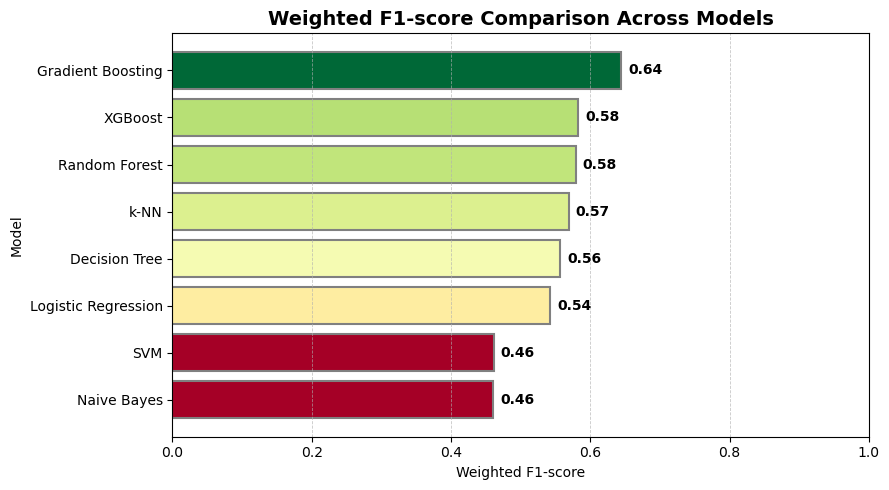

In [20]:
import matplotlib.pyplot as plt

# Prepare and sort weighted F1-scores (best first)
f1_results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=le_target.classes_, output_dict=True)
    f1_results[name] = report["weighted avg"]["f1-score"]

f1_df = pd.DataFrame.from_dict(f1_results, orient="index", columns=["F1-score"]).sort_values(by="F1-score", ascending=False)

# Normalize F1-scores for color mapping
norm = (f1_df["F1-score"] - f1_df["F1-score"].min()) / (f1_df["F1-score"].max() - f1_df["F1-score"].min())
cmap = plt.colormaps['RdYlGn']
colors = cmap(norm)

# Horizontal bar plot: best model will be at the bottom, so invert y-axis!
fig, ax = plt.subplots(figsize=(9, 5))
bars = ax.barh(f1_df.index, f1_df["F1-score"], color=colors, edgecolor="gray", linewidth=1.5)

for i, (val, ytick) in enumerate(zip(f1_df["F1-score"].round(3), f1_df.index)):
    ax.text(val + 0.01, i, f"{val:.2f}", va='center', color='black', fontweight='bold')

ax.set_xlim(0, 1)
ax.set_xlabel("Weighted F1-score")
ax.set_ylabel("Model")
ax.set_title("Weighted F1-score Comparison Across Models", fontsize=14, fontweight='bold')
ax.grid(axis='x', linestyle='--', linewidth=0.6, alpha=0.7)
ax.invert_yaxis()  # <-- This puts the best model at the top!
plt.tight_layout()
plt.show()